# Analyze performance of LSTM (Model 1) on Shasta Reservoir

In this notebook, we analyze the performance of LSTM Model 1 using data from Shasta reservoir. Recall that LSTM Model 2 takes in inflow and the day of the year (DOY) as input, and outputs the predicted release. This notebook is organized in serveral sections:

1. Data processing: manipulate data to use with the models
2. Analyze optimal hyperparameters, using results from grid search conducted in 1_model1_tuning.py
3. Plot performance on train, val, test sets. Get R2 measure.
4. Analyze relationship between cell states and observed storage

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os

In [2]:
print(f'Old working directory: {os.getcwd()}')
# change directory out of subdirectory 'experiments'
os.chdir('..')
print(f'Current working directory: {os.getcwd()}')

Old working directory: c:\Users\mattc\Documents\DL-reservoir-modeling\experiments
Current working directory: c:\Users\mattc\Documents\DL-reservoir-modeling


## Data Processing

In [3]:
from src.data.data_processing import *
from src.data.data_fetching import *

In [4]:
# Read in data, columns are [inflow, outflow, storage]
df = usbr_fetch_data(name='Shasta', vars=['inflow', 'outflow', 'storage'])

In [5]:
# Add day of the year (doy) as another column
df['doy'] = df.index.to_series().dt.dayofyear

In [6]:
# Select data window (beginning of 1944 to end of 2022)
df = df['1944-01-01':'2022-12-31'].copy()

In [7]:
# Run data processing pipeline
pipeline = processing_pipeline(train_frac=0.6, val_frac=0.2, test_frac=0.2, chunk_size=3*365, pad_value=-1)
# train and val of shape (#chunks, chunksize, [inflow, outflow, storage, doy]), 
# test of shape (timesteps, [inflow, outflow, storage, doy])
ts_train, ts_val, ts_test = pipeline.process_data(df) 

In [8]:
## Separate inputs(X) and targets (y)

# select inflow and doy as input features
X_train, X_val, X_test = ts_train[:, :, [0, 3]], ts_val[:, :, [0, 3]], ts_test[:, :, [0, 3]]
# select outflow as target feature
y_train, y_val, y_test = ts_train[:, :, [1]], ts_val[:, :, [1]], ts_test[:, :, [1]]

In [9]:
# Create PyTorch dataset and dataloader
dataset_train, dataset_val = (TensorDataset(X_train, y_train), TensorDataset(X_val, y_val))
# shuffle = False to preserve time order
dataloader_train, dataloader_val = (DataLoader(dataset_train, batch_size=1, shuffle=False), 
                                                     DataLoader(dataset_val, batch_size=1, shuffle=False))

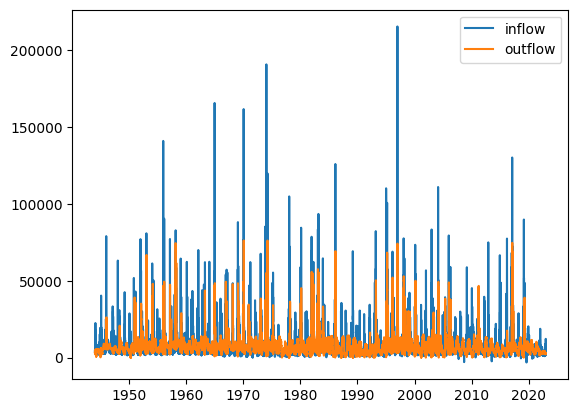

In [10]:
plt.plot(df.inflow)
plt.plot(df.outflow)
plt.legend(['inflow', 'outflow'])

## Analyze Optimal Hyperparameters
Previously, we conducted a grid search over a predefined parameter space: \
Number LSTM layers; 1, 2\
Hidden size (LSTM): 5, 10, 15, 20, 25, 30, 35, 40, 45, 50\
Hidden size (FF): 5, 10, 15, 20, 25, 30, 35, 40, 45, 50\
Dropout probability: 0.3, 0.5, 0.7

On 5 random seeds: 0, 10, 100, 1000, 10000 which we want to average performance over.

In [11]:
from src.models.model_zoo import *
from src.models.train_model import *

In [12]:
# load in results from grid search
grid_df = pd.read_csv('report/results/hyperparameter_tuning/model1_tuning.csv', index_col=0)

In [13]:
# average performance over the random seeds
num_random_seeds = 5
grid_df['param_id'] = np.repeat(np.arange(int(len(grid_df) / num_random_seeds)), num_random_seeds)
grid_df_mean = grid_df.groupby('param_id').mean()
grid_df_mean.drop(columns=['random_seed'], inplace=True)

In [14]:
# save sorted df
grid_df_mean.sort_values(by=['val_error'], axis=0, inplace=True)
grid_df_mean.to_csv('report/results/hyperparameter_tuning/model1_avg_tuning.csv')

In [15]:
grid_df_mean[:10]

,num_layers,hidden1,hidden2,dropout,epochs_trained,val_error
param_id,,,,,,
306,1.0,30.0,15.0,0.3,74.2,0.363413
324,1.0,30.0,45.0,0.3,60.8,0.368881
138,1.0,15.0,35.0,0.3,107.2,0.372677
441,1.0,40.0,40.0,0.3,68.2,0.374502
555,1.0,50.0,30.0,0.3,64.0,0.375822
319,1.0,30.0,35.0,0.5,89.8,0.377301
307,1.0,30.0,15.0,0.5,95.2,0.378819
315,1.0,30.0,30.0,0.3,62.2,0.378953
564,1.0,50.0,45.0,0.3,63.4,0.379373


In [16]:
int(grid_df_mean.iloc[0].hidden1)

30

### Load model based on optimal hyperparameters
Number  of LSTM layers: 1\
LSTM hidden units: 30\
FF hidden units: 15\
dropout: 0.3

In [17]:
# instantiate model
input_size = 2
hidden_size1 = 30
hidden_size2 = 15
output_size = 1
dropout_prob = 0.3
num_layers = 1

torch.manual_seed(0)
model1 = LSTMModel1(input_size=input_size, hidden_size1=hidden_size1, 
                             hidden_size2=hidden_size2, output_size=output_size, dropout_prob=dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

In [18]:
count_parameters(model1)

4561

In [19]:
# load saved model
model1.load_state_dict(torch.load('src/models/saved_models/model1.pt'))

<All keys matched successfully>

## Evaluate Model 1


In [20]:
from src.models.predict_model import *
from sklearn.metrics import r2_score

In [21]:
# turn model into evaluation model
model1.eval()

LSTMModel1(
  (lstm_cell): LSTMCell(2, 30)
  (dropout1): Dropout(p=0.3, inplace=False)
  (linear1): Linear(in_features=30, out_features=15, bias=True)
  (relu1): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (linear2): Linear(in_features=15, out_features=1, bias=True)
)

### Evaluate performance in training

In [22]:
# flatten and remove pads
y_hat_train, y_true_train = flatten_rm_pad(y_hat=model1(X_train)[0].detach(), y=y_train)

# check dimensions of datetime
original_train_len = int(round(df['1944-01-01':'2022-12-31'].shape[0] * pipeline.train_frac))
original_val_len = int(round(df['1944-01-01':'2022-12-31'].shape[0] * pipeline.val_frac))
original_test_len = df['1944-01-01':'2022-12-31'].shape[0] - (original_train_len + original_val_len)

assert len(y_true_train) == original_train_len

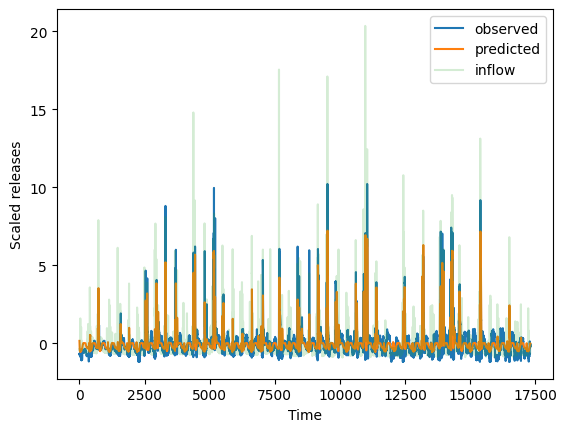

In [23]:
plot_predicted_true(y_hat=y_hat_train, y=y_true_train)
plt.plot(((df.inflow[:(original_train_len)] - df.inflow[:(original_train_len)].mean()) / df.inflow[:(original_train_len)].std()).values, 
         alpha=0.2, label='inflow')
plt.legend()
plt.show()

In [24]:
# R-squared
r2_score(y_true=y_true_train, y_pred=y_hat_train)

0.7314395431004055

### Evaluate performance in testing

In [25]:
# flatten and remove pads
y_hat_test, y_true_test = flatten_rm_pad(y_hat=model1(X_test)[0].detach(), y=y_test)
# check dimensions
assert len(y_true_test) == len(df.index) - (original_train_len + original_val_len)

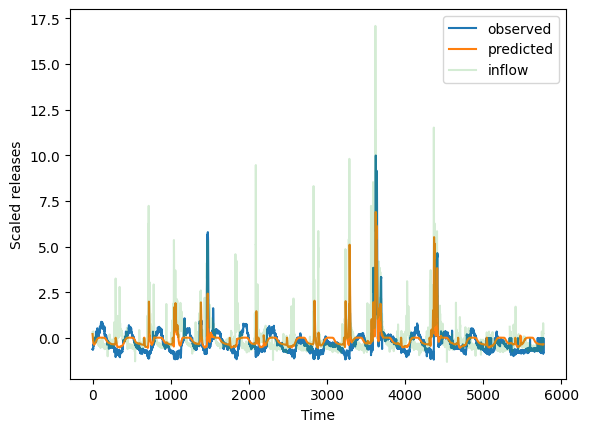

In [26]:
plot_predicted_true(y_hat=y_hat_test, y=y_true_test)
plt.plot(((df.inflow[(original_train_len+original_val_len):] - df.inflow[(original_train_len+original_val_len):].mean()) / df.inflow[(original_train_len+original_val_len):].std()).values, 
         alpha=0.2, label='inflow')
plt.legend()
plt.show()

In [27]:
# R-squared
r2_score(y_true=y_true_test, y_pred=y_hat_test)

0.43345771749112927

### Performance on the validation set (for reference)

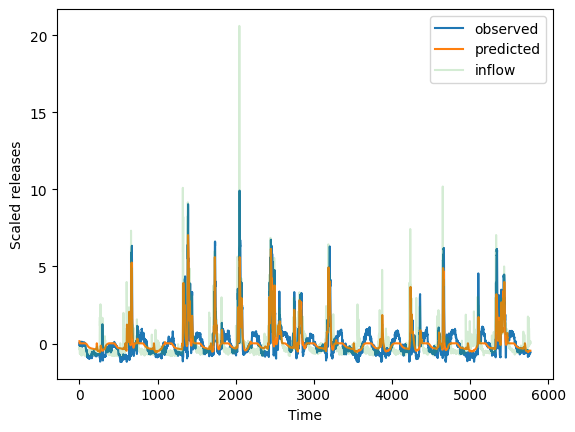

In [28]:
y_hat_val, y_true_val = flatten_rm_pad(y_hat=model1(X_val)[0].detach(), y=y_val)
assert len(y_true_val) == original_val_len

plot_predicted_true(y_hat=y_hat_val, y=y_true_val)
plt.plot(((df.inflow[original_train_len:(original_train_len+original_val_len)] - df.inflow[original_train_len:(original_train_len+original_val_len)].mean()) / df.inflow[original_train_len:(original_train_len+original_val_len)].std()).values, 
         alpha=0.2, label='inflow')
plt.legend()
plt.show()

In [29]:
r2_score(y_true_val, y_hat_val)

0.6861856266245214

In testing, the model exhibits far more "phantom" peaks compared to the validation and training sets. Performance in testing is also far lower than performance on the validation set. Could this be indicative of a policy change? Additionally note that the test set is much drier than the other datasets.

## Analyze cell memory states

### Analyze correlations

In [30]:
from src.models.analyze_lstm_cell import *

In [31]:
# Get cell states, shape is (# chunks, timesteps, hidden size)
cell_train = model1(X_train)[1].detach()
cell_val = model1(X_val)[1].detach()
cell_test = model1(X_test)[1].detach()

In [32]:
# Get storage states, shape is (timesteps, )
storage_train = df.storage[:original_train_len].values
storage_val = df.storage[original_train_len:(original_train_len+original_val_len)].values
storage_test = df.storage[(original_train_len+original_val_len):].values

In [33]:
correlation_data = {'training':cell_correlations(cell_states=cell_train, storage_states=storage_train),
                    'validation': cell_correlations(cell_states=cell_val, storage_states=storage_val),
                    'testing': cell_correlations(cell_states=cell_test, storage_states=storage_test)}
df_corr = pd.DataFrame(correlation_data)
df_corr

,training,validation,testing
0,-0.267901,-0.378877,-0.374575
1,-0.362238,-0.489812,-0.452836
2,0.094986,0.177543,0.150789
3,0.250258,0.351130,0.342662
4,-0.201518,-0.328892,-0.317638
5,-0.261197,-0.299407,-0.262191
6,0.112620,0.163081,0.138093
7,0.383135,0.572954,0.482583
8,0.308736,0.449045,0.431485
9,0.010493,-0.140732,-0.049126


In [34]:
# Select cell with correlation > 0.30
df_corr.loc[df_corr['training'] > 0.30, :].sort_values(by='testing', ascending=False)

,training,validation,testing
20,0.433498,0.630791,0.520652
18,0.412510,0.589280,0.495587
7,0.383135,0.572954,0.482583
29,0.345650,0.562985,0.462216
8,0.308736,0.449045,0.431485


### Plot cell states vs storage in training

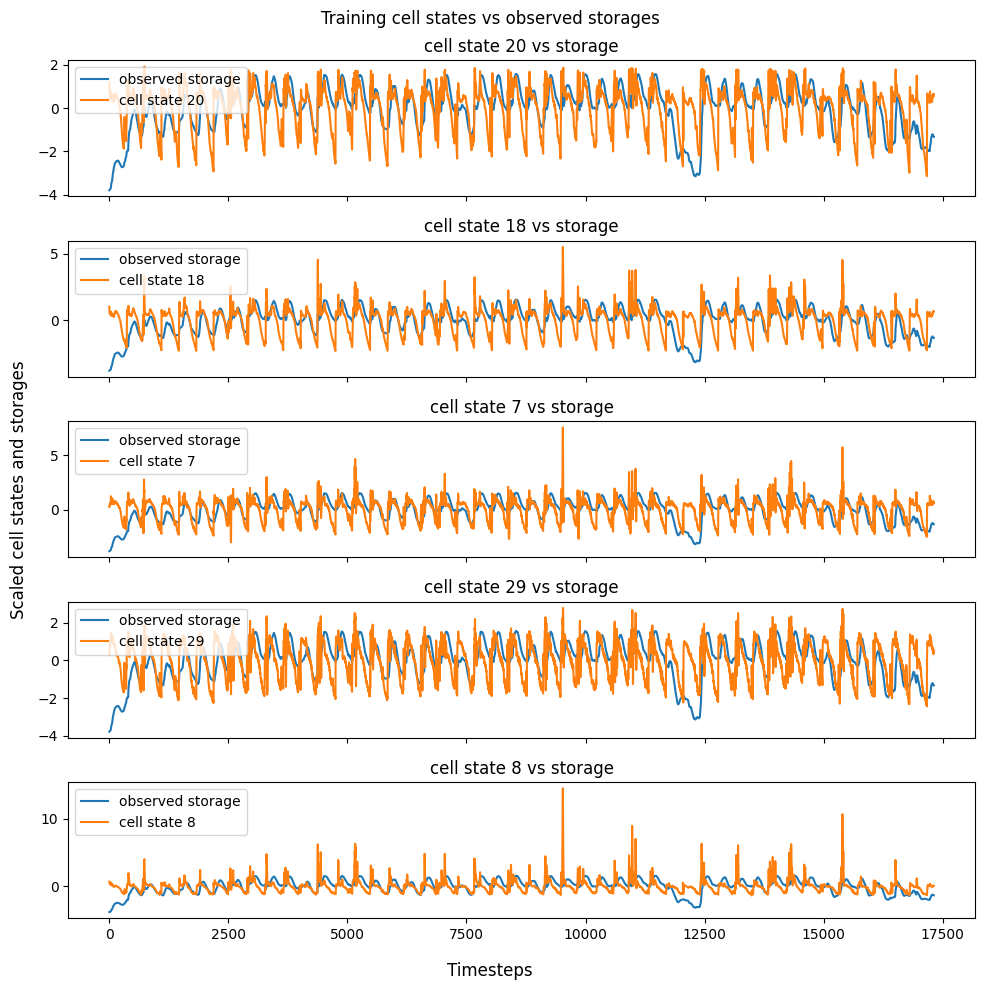

In [35]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 10), sharex=True)
plot_storage_cell(cell_states_all=cell_train, storage_states=storage_train, cell_id=20, ax=axes[0])
plot_storage_cell(cell_states_all=cell_train, storage_states=storage_train, cell_id=18, ax=axes[1])
plot_storage_cell(cell_states_all=cell_train, storage_states=storage_train, cell_id=7, ax=axes[2])
plot_storage_cell(cell_states_all=cell_train, storage_states=storage_train, cell_id=29, ax=axes[3])
plot_storage_cell(cell_states_all=cell_train, storage_states=storage_train, cell_id=8, ax=axes[4])

axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')
axes[2].legend(loc='upper left')
axes[3].legend(loc='upper left')
axes[4].legend(loc='upper left')

fig.supxlabel('Timesteps')
fig.supylabel('Scaled cell states and storages')
fig.suptitle('Training cell states vs observed storages')
plt.tight_layout()
plt.show()

### Plot cell states vs storage in testing

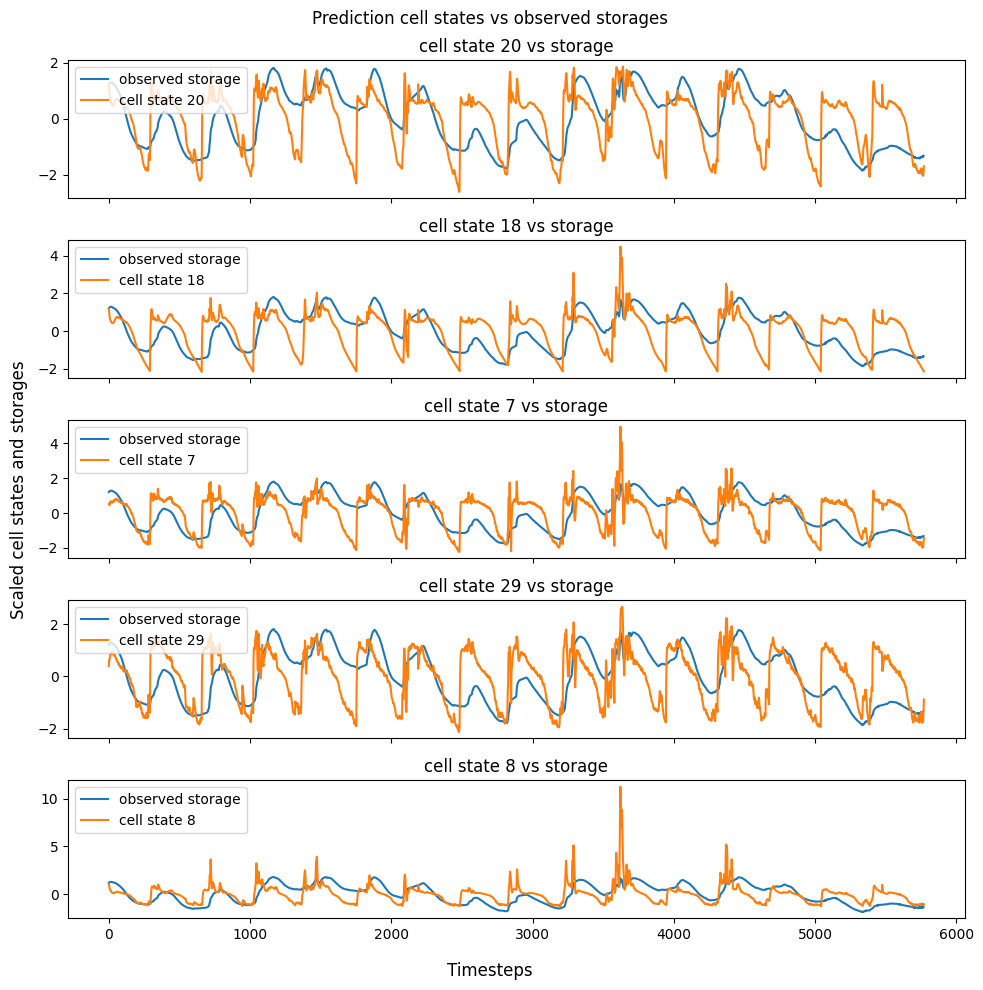

In [36]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 10), sharex=True)
plot_storage_cell(cell_states_all=cell_test, storage_states=storage_test, cell_id=20, ax=axes[0])
plot_storage_cell(cell_states_all=cell_test, storage_states=storage_test, cell_id=18, ax=axes[1])
plot_storage_cell(cell_states_all=cell_test, storage_states=storage_test, cell_id=7, ax=axes[2])
plot_storage_cell(cell_states_all=cell_test, storage_states=storage_test, cell_id=29, ax=axes[3])
plot_storage_cell(cell_states_all=cell_test, storage_states=storage_test, cell_id=8, ax=axes[4])

axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')
axes[2].legend(loc='upper left')
axes[3].legend(loc='upper left')
axes[4].legend(loc='upper left')

fig.supxlabel('Timesteps')
fig.supylabel('Scaled cell states and storages')
fig.suptitle('Prediction cell states vs observed storages')
plt.tight_layout()
plt.show()

### Plot cell states vs storage in validation (for reference)

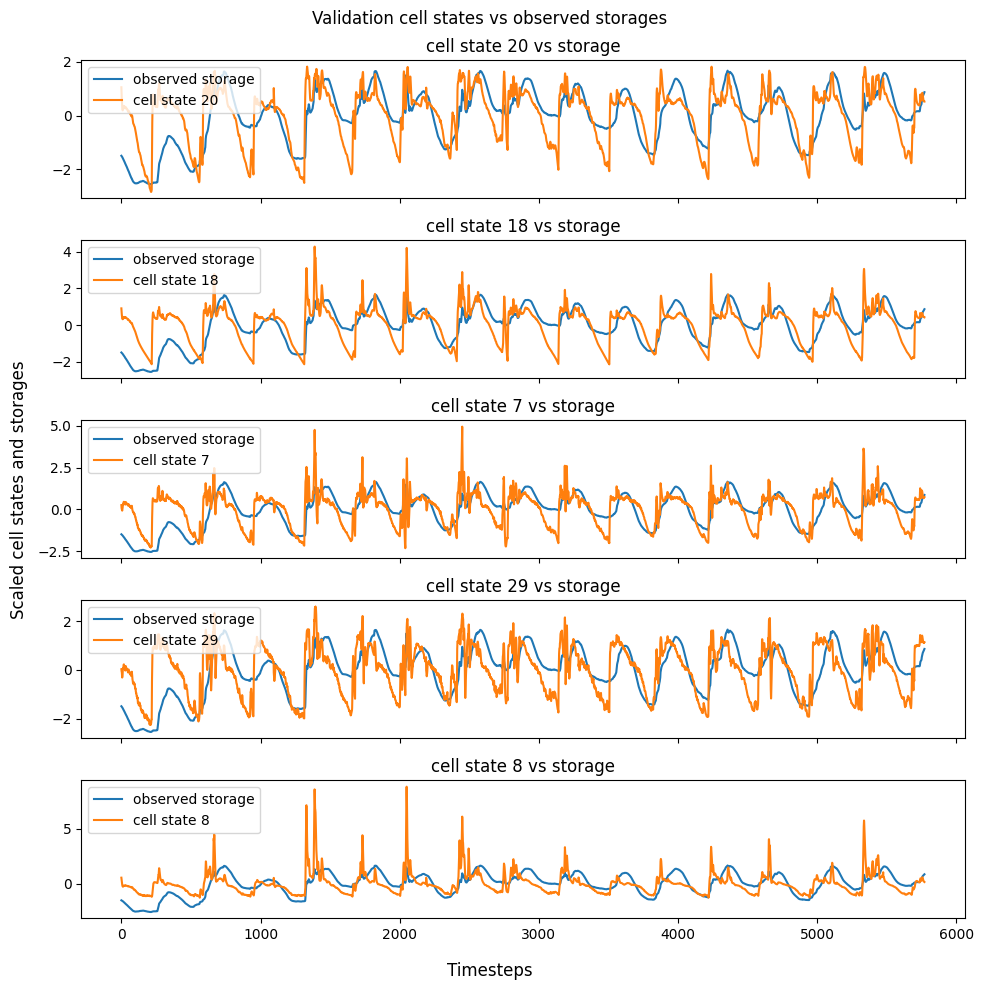

In [37]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 10), sharex=True)
plot_storage_cell(cell_states_all=cell_val, storage_states=storage_val, cell_id=20, ax=axes[0])
plot_storage_cell(cell_states_all=cell_val, storage_states=storage_val, cell_id=18, ax=axes[1])
plot_storage_cell(cell_states_all=cell_val, storage_states=storage_val, cell_id=7, ax=axes[2])
plot_storage_cell(cell_states_all=cell_val, storage_states=storage_val, cell_id=29, ax=axes[3])
plot_storage_cell(cell_states_all=cell_val, storage_states=storage_val, cell_id=8, ax=axes[4])

axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')
axes[2].legend(loc='upper left')
axes[3].legend(loc='upper left')
axes[4].legend(loc='upper left')

fig.supxlabel('Timesteps')
fig.supylabel('Scaled cell states and storages')
fig.suptitle('Validation cell states vs observed storages')
plt.tight_layout()
plt.show()

The model appears to learn the seasonality of observed storages, but not their actual values.